<H1>DATA</H1>

In [1]:
from google.cloud import bigquery
import pandas as pd

# Khởi tạo BigQuery client
client = bigquery.Client.from_service_account_json("Key/gg_big_query.json")

# Viết query
query = """
DECLARE day_before INT64 DEFAULT 7;

SELECT
  DATE(DATETIME_ADD(pos.inserted_at, INTERVAL 7 HOUR)) AS date_insert,
  pos.brand,
  CASE
    WHEN pos.order_sources_name IN ('Ladipage Facebook', 'Webcake') THEN 'Facebook'
    WHEN pos.order_sources_name = 'Ladipage Tiktok' THEN 'Tiktok'
    ELSE pos.order_sources_name
  END AS channel,
  JSON_VALUE(item, '$.variation_info.display_id') AS sku,
  JSON_VALUE(item, '$.variation_info.name') AS product_name,
  price.gia_ban_daily AS daily_price,
  SUM(SAFE_CAST(JSON_VALUE(item, '$.quantity') AS INT64)) AS total_quantity,
  SUM(SAFE_CAST(JSON_VALUE(item, '$.quantity') AS INT64)) * IFNULL(price.gia_ban_daily, 0) AS total_amount
FROM `crypto-arcade-453509-i8.dtm.t1_pancake_pos_order_total` AS pos
CROSS JOIN UNNEST(items) AS item
LEFT JOIN (
  SELECT
    ma_sku AS sku,
    gia_ban_daily
  FROM `crypto-arcade-453509-i8.dtm.t1_bang_gia_san_pham`
) AS price
  ON JSON_VALUE(item, '$.variation_info.display_id') = price.sku
WHERE DATE(pos.inserted_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL day_before DAY)
  AND DATE(pos.inserted_at) < CURRENT_DATE()
GROUP BY
  date_insert,
  pos.brand,
  channel,
  sku,
  product_name,
  daily_price
ORDER BY
  date_insert,
  pos.brand;
"""

# Lấy dữ liệu về DataFrame và đặt tên là history
history = client.query(query).to_dataframe()

history

,date_insert,brand,channel,sku,product_name,daily_price,total_quantity,total_amount
0,2025-09-11,An Cung,Shopee,AC-004,Hũ Hít Mũi Thảo Mộc An Cung 8g,75000.0,35,2625000.0
1,2025-09-11,An Cung,Tiktok,AC-004,Hũ Hít Mũi Thảo Mộc An Cung 8g,75000.0,390,29250000.0
2,2025-09-11,An Cung,Shopee,TH-165,Combo 2 Hũ Hít Mũi Thảo Mộc An Cung 8g,155000.0,11,1705000.0
3,2025-09-11,An Cung,Tiktok,TH-165,Combo 2 Hũ Hít Mũi Thảo Mộc An Cung 8g,155000.0,13,2015000.0
4,2025-09-11,An Cung,Tiktok,AC-007,DẦU XOA BÓP ANCUNG,NaN,4,0.0
...,...,...,...,...,...,...,...,...
3180,2025-09-18,UME,Shopee,NTB-008,"Kem kích trắng body UME hỗ trợ dưỡng sáng da, ...",30000.0,1,30000.0
3181,2025-09-18,UME,Facebook,NTB-010,"Sữa Tắm Hương Nước Hoa U9 UME Sạch Sâu, Lưu Hư...",355000.0,3,1065000.0
3182,2025-09-18,UME,Tiktok,NTB-011,Kem Chống Nắng Nâng Tông UME SPF50+/PA++++ Chố...,450000.0,1,450000.0
3183,2025-09-18,UME,Facebook,NTB-006,"Kem Dưỡng Ẩm Body UME Cấp Ẩm Sâu, Phục Hồi, Mề...",30000.0,1,30000.0


<H1>ANALYSIS</H1>

In [7]:
import pandas as pd
import numpy as np

# ================== CONFIG ==================
SHORT_WIN = 3   # EMA ngắn
LONG_WIN = 7    # EMA dài
SIGNAL_WIN = 5  # Signal

# ================== GROUP & TREND DETECTION ==================
def detect_trend(df):
    # Sắp xếp theo ngày
    df = df.sort_values("date_insert")
    
    # Tính EMA ngắn & dài
    df["ema_short"] = df["total_amount"].ewm(span=SHORT_WIN, adjust=False).mean()
    df["ema_long"] = df["total_amount"].ewm(span=LONG_WIN, adjust=False).mean()
    
    # MACD = EMA ngắn - EMA dài
    df["macd"] = df["ema_short"] - df["ema_long"]
    # Signal line
    df["signal"] = df["macd"].ewm(span=SIGNAL_WIN, adjust=False).mean()
    # Histogram = MACD - Signal
    df["hist"] = df["macd"] - df["signal"]
    
    # Xu hướng = dấu của MACD
    trend_type = "Tăng" if df["macd"].iloc[-1] > df["signal"].iloc[-1] else "Giảm"
    
    # Cường độ xu hướng: scale histogram về 0–100
    hist_scaled = np.interp(
        df["hist"].iloc[-1],
        (df["hist"].min(), df["hist"].max()),
        (0, 100)
    )
    
    return pd.Series({
        "trend_type": trend_type, 
        "trend_strength": round(hist_scaled, 2)
    })

# ================== RUN ==================
trend_result = (
    history.groupby(["brand", "channel", "product_name"])
    .apply(detect_trend)
    .reset_index()
    .sort_values("trend_strength", ascending=False)  # sort từ cao xuống thấp
    .reset_index(drop=True)
)

trend_result

,brand,channel,product_name,trend_type,trend_strength
0,An Cung,,AN CUNG THANG THẢO MỘC XÔNG MŨI CUNG ĐÌNH - 1 ...,Giảm,100.0
1,LYB,Facebook,Áo bra LYB trể vai tay dài - LYB PLUS TOP,Giảm,100.0
2,LYB,Facebook,Quần suông ống rộng cá tính thời trang nhiều màu,Giảm,100.0
3,LYB,Facebook,Set vest gồm áo vest blazer và quần công sở dà...,Giảm,100.0
4,LYB,Facebook,"Set vest nữ LYB gồm vest, áo bra và quần công ...",Giảm,100.0
...,...,...,...,...,...
332,UME,Tiktok,Bọt Rửa Mặt Cam Đỏ UME Blood Orange Foaming Cl...,Giảm,0.0
333,Chaching,Facebook,[BEST SELLER] Mũ Nón Lưỡi Trai Unisex Thêu Log...,Giảm,0.0
334,An Cung,Tiktok,COMBO 3 GỘI XẢ XỊT TÓC THẢO MỘC AN CUNG,Giảm,0.0
335,UME,Tiktok,Combo 2 Dung Dịch Vệ Sinh Phụ Nữ Tía Tô UME Gi...,Giảm,0.0


In [8]:
trend_result[trend_result['trend_type'] == "Tăng"]

,brand,channel,product_name,trend_type,trend_strength
11,LYB,Facebook,Son nách LYB chiết xuất tự nhiên khử mùi giảm ...,Tăng,100.00
30,LYB,Facebook,LYB Quần Legging Đùi Lửng Nữ Cạp Cao | Co Giãn...,Tăng,100.00
33,LYB,Facebook,"LYB - Áo Khoác Thể Thao Nữ Tay Dài Khóa Kéo, Á...",Tăng,100.00
55,LYB,Facebook,Chân váy LYB xếp ly cổ điển - LYB CLASSIC SKIR,Tăng,100.00
56,LYB,Facebook,Chân váy LYB xếp ly thắt nơ có ren viền chất c...,Tăng,100.00
70,UME,Tiktok,Bộ 3 Dưỡng Trắng Da Body UME - Kem Ủ Trắng & T...,Tăng,100.00
73,UME,Tiktok,"Kem Dưỡng Trắng Body UME Cấp Ẩm Mịn Màng, Hỗ T...",Tăng,100.00
93,UME,Facebook,Nước Tẩy Trang Cam Đỏ UME Blood Orange Micella...,Tăng,100.00
94,UME,Facebook,"Kem Ủ Trắng Body 200gr UME Làm Sạch Sâu, Mịn D...",Tăng,100.00
95,UME,Facebook,"Kem Dưỡng Ẩm Body UME Cấp Ẩm Sâu, Phục Hồi, Mề...",Tăng,100.00


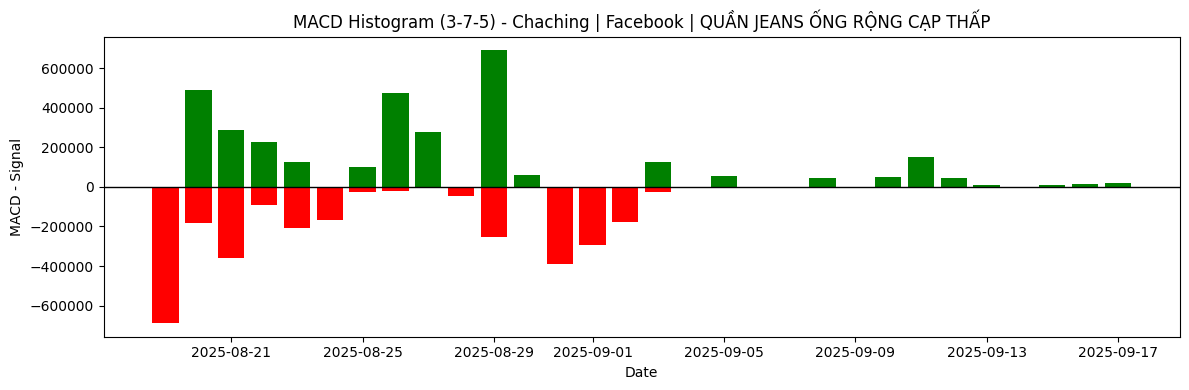

In [13]:
import matplotlib.pyplot as plt

# ================== CONFIG ==================
SHORT_WIN = 3   # EMA ngắn
LONG_WIN = 7    # EMA dài
SIGNAL_WIN = 5  # Signal

brand_filter = "Chaching"
channel_filter = "Facebook"
product_filter = "QUẦN JEANS ỐNG RỘNG CẠP THẤP"

# ================== FILTER DATA ==================
df = history[
    (history["brand"] == brand_filter) &
    (history["channel"] == channel_filter) &
    (history["product_name"] == product_filter)
].copy()

df = df.sort_values("date_insert")

# ================== CALCULATE MACD ==================
df["ema_short"] = df["total_amount"].ewm(span=SHORT_WIN, adjust=False).mean()
df["ema_long"] = df["total_amount"].ewm(span=LONG_WIN, adjust=False).mean()
df["macd"] = df["ema_short"] - df["ema_long"]
df["signal"] = df["macd"].ewm(span=SIGNAL_WIN, adjust=False).mean()
df["hist"] = df["macd"] - df["signal"]

# ================== PLOT HISTOGRAM ==================
plt.figure(figsize=(12, 4))
plt.bar(df["date_insert"], df["hist"], 
        color=["green" if h >= 0 else "red" for h in df["hist"]])
plt.axhline(0, color="black", linewidth=1)
plt.title(f"MACD Histogram (3-7-5) - {brand_filter} | {channel_filter} | {product_filter}")
plt.xlabel("Date")
plt.ylabel("MACD - Signal")
plt.tight_layout()
plt.show()

<H1>EXPORT</H1>

In [2]:
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe

# ==== KẾT NỐI GOOGLE SHEET ====
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
creds = Credentials.from_service_account_file('Key/google_sheet.json', scopes=SCOPES)
gc = gspread.authorize(creds)

# ==== MỞ FILE GOOGLE SHEET ====
target_url = 'https://docs.google.com/spreadsheets/d/1pTH3minpoZMoT1xicadDF3WCSqKNugrUvplcpS9U__8/edit?gid=0'
spreadsheet = gc.open_by_url(target_url)

# ==== TÌM SHEET "data" (HOẶC TẠO MỚI NẾU CHƯA CÓ) ====
try:
    worksheet = spreadsheet.worksheet("data")
except gspread.exceptions.WorksheetNotFound:
    worksheet = spreadsheet.add_worksheet(title="data", rows=1000, cols=20)

# ==== XOÁ DỮ LIỆU CŨ (GIỮ LẠI SHEET) ====
worksheet.clear()

# ==== GHI DỮ LIỆU forecast VÀO SHEET "data" ====
set_with_dataframe(worksheet, history, include_index=False)